In [47]:
from math import radians, cos, sin, asin, sqrt, ceil, floor
from scipy.interpolate import griddata
from scipy import ndimage

import pandas as pd
import scipy
from sklearn.neighbors import KNeighborsClassifier as KNN
import matplotlib.pyplot as plt
import numpy as np
import json
import re

In [2]:
df = pd.read_csv('Crime_Data_from_2010_to_Present.csv')

In [3]:
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,1307355,02/20/2010 12:00:00 AM,02/20/2010 12:00:00 AM,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,...,AA,Adult Arrest,900.0,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695
1,11401303,09/13/2010 12:00:00 AM,09/12/2010 12:00:00 AM,45,14,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962
2,70309629,08/09/2010 12:00:00 AM,08/09/2010 12:00:00 AM,1515,13,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,...,IC,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524
3,90631215,01/05/2010 12:00:00 AM,01/05/2010 12:00:00 AM,150,6,Hollywood,646,2,900,VIOLATION OF COURT ORDER,...,IC,Invest Cont,900.0,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295
4,100100501,01/03/2010 12:00:00 AM,01/02/2010 12:00:00 AM,2100,1,Central,176,1,122,"RAPE, ATTEMPTED",...,IC,Invest Cont,122.0,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488


In [4]:
df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA ', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

In [5]:
#drop columns irrelevant to our data analysis
drop_cols = [
    'DR_NO',
    'Date Rptd',
    'AREA ',
    'Rpt Dist No',
    'Part 1-2',
    'Crm Cd',
    'Premis Cd',
    'Premis Desc',
    'Weapon Used Cd',
    'Weapon Desc',
    'Mocodes',
    'Status',
    'Status Desc',
    'Crm Cd 1',
    'Crm Cd 2',
    'Crm Cd 3',
    'Crm Cd 4',
    'Cross Street',
    'LOCATION',
]

df = df.drop(drop_cols, axis=1)
df.columns

Index(['DATE OCC', 'TIME OCC', 'AREA NAME', 'Crm Cd Desc', 'Vict Age',
       'Vict Sex', 'Vict Descent', 'LAT', 'LON'],
      dtype='object')

In [6]:
df.head()

,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,LAT,LON
0,02/20/2010 12:00:00 AM,1350,Newton,VIOLATION OF COURT ORDER,48,M,H,33.9825,-118.2695
1,09/12/2010 12:00:00 AM,45,Pacific,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,W,33.9599,-118.3962
2,08/09/2010 12:00:00 AM,1515,Newton,OTHER MISCELLANEOUS CRIME,0,M,H,34.0224,-118.2524
3,01/05/2010 12:00:00 AM,150,Hollywood,VIOLATION OF COURT ORDER,47,F,W,34.1016,-118.3295
4,01/02/2010 12:00:00 AM,2100,Central,"RAPE, ATTEMPTED",47,F,H,34.0387,-118.2488


In [7]:
# clean up date occurred to only contain month/day/year
temp = df['DATE OCC'].str.split(' ',n = 1, expand = True)
temp2 = temp[0]
df['DATE OCC'] = temp2

In [8]:
df.head()

,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,LAT,LON
0,02/20/2010,1350,Newton,VIOLATION OF COURT ORDER,48,M,H,33.9825,-118.2695
1,09/12/2010,45,Pacific,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,W,33.9599,-118.3962
2,08/09/2010,1515,Newton,OTHER MISCELLANEOUS CRIME,0,M,H,34.0224,-118.2524
3,01/05/2010,150,Hollywood,VIOLATION OF COURT ORDER,47,F,W,34.1016,-118.3295
4,01/02/2010,2100,Central,"RAPE, ATTEMPTED",47,F,H,34.0387,-118.2488


In [9]:
df['Crm Cd Desc'].unique()

array(['VIOLATION OF COURT ORDER',
       'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
       'OTHER MISCELLANEOUS CRIME', 'RAPE, ATTEMPTED',
       'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
       'BURGLARY FROM VEHICLE',
       'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
       'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
       'BATTERY - SIMPLE ASSAULT', 'ROBBERY', 'BOMB SCARE',
       'CHILD NEGLECT (SEE 300 W.I.C.)',
       'INTIMATE PARTNER - AGGRAVATED ASSAULT',
       'INTIMATE PARTNER - SIMPLE ASSAULT',
       'THEFT PLAIN - PETTY ($950 & UNDER)',
       'CRIMINAL THREATS - NO WEAPON DISPLAYED', 'ATTEMPTED ROBBERY',
       'VANDALISM - MISDEAMEANOR ($399 OR UNDER)', 'BURGLARY', 'ARSON',
       'RAPE, FORCIBLE', 'BRANDISH WEAPON',
       'THROWING OBJECT AT MOVING VEHICLE',
       'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)',
       'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT',
       'SHOTS FIRED AT INHABITED DWELLING',
       'THEFT FROM MOTOR

In [10]:
# drop crimes that are not deemed threatening to civilians
drop_crimes = set([
    'ABORTION/ILLEGAL',
    'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM',
    'BIGAMY',
    'BLOCKING DOOR INDUCTION CENTER',
    'BOAT - STOLEN',
    'CONSPIRACY',
    'CREDIT CARDS, FRAUD USE ($950 & UNDER',
    'CREDIT CARDS, FRAUD USE ($950.01 & OVER)',
    'CONTEMPT OF COURT',
    'CONTRIBUTING',
    'COUNTERFEIT',
    'CRUELTY TO ANIMALS',
    'DEFRAUDING INNKEEPER/THEFT OF SERVICES, $400 & UNDER',
    'DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $400',
    'DISHONEST EMPLOYEE - GRAND THEFT',
    'DISHONEST EMPLOYEE - PETTY THEFT',
    'DISHONEST EMPLOYEE ATTEMPTED THEFT',
    'DOCUMENT FORGERY / STOLEN FELONY',
    'DOCUMENT WORTHLESS ($200 & UNDER)',
    'DOCUMENT WORTHLESS ($200.01 & OVER)',
    'DRIVING WITHOUT OWNER CONSENT (DWOC)',
    'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)',
    'EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)',
    'FAILURE TO YIELD',
    'FALSE IMPRISONMENT',
    'FALSE POLICE REPORT',
    'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD',
    'PANDERING',
    'REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)',
    'TELEPHONE PROPERTY - DAMAGE',
    'THEFT OF IDENTITY',
    'UNAUTHORIZED COMPUTER ACCESS',
    'VIOLATION OF COURT ORDER',
    
])

df = df[~df['Crm Cd Desc'].isin(drop_crimes)]

In [11]:
#merging latitude and longitude into new column `COORDS`

# df['COORDS'] = list(zip(df['LAT'],df['LON']))
# df.drop(columns = ['LAT','LON'], axis = 1, inplace = True)

In [13]:
df.head()

,index,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,LAT,LON
0,1,09/12/2010,45,Pacific,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,W,33.9599,-118.3962
1,2,08/09/2010,1515,Newton,OTHER MISCELLANEOUS CRIME,0,M,H,34.0224,-118.2524
2,4,01/02/2010,2100,Central,"RAPE, ATTEMPTED",47,F,H,34.0387,-118.2488
3,5,01/04/2010,1650,Central,SHOPLIFTING - PETTY THEFT ($950 & UNDER),23,M,B,34.0480,-118.2577
4,6,01/07/2010,2005,Central,BURGLARY FROM VEHICLE,46,M,H,34.0389,-118.2643


In [14]:
df['AREA NAME'].unique()

array(['Pacific', 'Newton', 'Central', 'Northeast', 'Hollenbeck',
       'Southwest', 'Southeast', 'Rampart', 'Olympic', 'Harbor',
       'Hollywood', '77th Street', 'Wilshire', 'West LA', 'Van Nuys',
       'West Valley', 'Topanga', 'N Hollywood', 'Mission', 'Foothill',
       'Devonshire'], dtype=object)

In [50]:
#drop all victimless crime
df.dropna(inplace = True)
df.reset_index(inplace = True)

1683147

In [48]:
#get max and min longitude
print('The max and min longitude values are ' + str(np.max(df['LON']) + '&' + str(np.min(df['LON']))
#get max and min latitude
np.max(df['LAT'])
#plot LAT v LON to visualize where crimes occur in LA


SyntaxError: invalid syntax (<ipython-input-48-c61fdd97ed2f>, line 4)

Text(0.5, 0, 'Longitude')

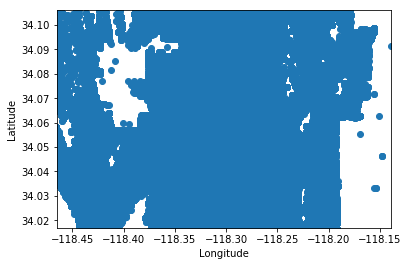

In [64]:
#plot of all crimes lat v lon
plt.scatter(df['LON'],df['LAT'])
plt.xlim([-118.465381,-118.138795])
plt.ylim([34.016907, 34.105999])
plt.ylabel('Latitude')
plt.xlabel('Longitude')

In [22]:
np.argmin(df['LON'])

C:\Users\Jacob\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


710150

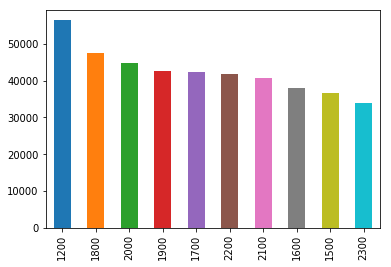

In [61]:
df['TIME OCC'].value_counts()[:10].plot(kind = 'bar')

f0 = plt.gcf()

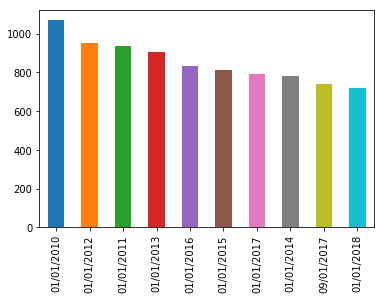

In [62]:
df['DATE OCC'].value_counts()[:10].plot(kind = 'bar')

f1 = plt.gcf()

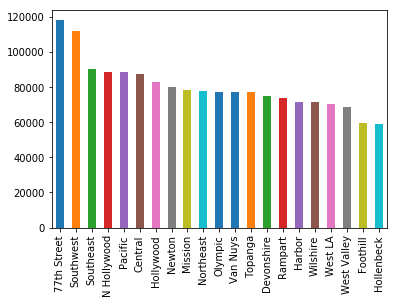

In [66]:
df['AREA NAME'].value_counts().plot(kind = 'bar')

f2 = plt.gcf()

In [ ]:
# split df into 2010-2012, 2013-2015, 2016-2018
#plot lat v lon in different colors to visualize where crime is happening in LA
#